# Point-A Reference Plan Optimization (v0.3)

This notebook revisits the previous `point_a_plan` workflow and adds a cvxpy-based dwell-time optimizer.
Tandem reference points are enforced at 100% of the prescription, while ovoid reference points are held at 140%.
The steps below load the brachy plan, assemble TG-43 influence matrices at the reference points, and solve a convex program that minimally perturbs the plan dwell times while satisfying the dose-rate requirements.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import copy

import SimpleITK as sitk

from pathlib import Path
from typing import Any, Dict, Iterable, List, Tuple

try:
    from IPython.display import display
except ImportError:  # pragma: no cover - fallback when running as a script
    def display(obj):
        print(obj)

from omegaconf import DictConfig, OmegaConf
from scipy.ndimage import gaussian_filter

import tg43.dicom_helper as dhelp
import tg43.contour_helper as chelp
import tg43.dose_calculation as dosecal
import tg43.utils as utils
import tg43.visualization as vis

import tg43.rtstruct_export as rtexport
import src.dataloader as dataloader

In [2]:
def load_hyperparams(config_path: Path) -> DictConfig:
    """Load run-time hyperparameters from YAML."""
    cfg = OmegaConf.load(config_path)
    return cfg


def resolve_single(path_iterable: Iterable[Path], description: str) -> Path:
    """Return the first existing path from ``path_iterable``."""
    candidates = sorted(path_iterable)
    if not candidates:
        raise FileNotFoundError(f"No files found for {description}.")
    return candidates[0]


def load_case_paths(root: Path, case_id: Path) -> Dict[str, Path]:
    """Collect CT/RTDICOM paths for a given case identifier."""
    case_dir = root / f"{case_id}"
    if not case_dir.exists():
        raise FileNotFoundError(f"Case directory not found: {case_dir}")

    return {
        "ct": resolve_single(case_dir.glob("CT*/*"), "CT series"),
        "dose": resolve_single(case_dir.glob("RTDOSE*/*/*.dcm"), "RTDOSE file"),
        "plan": resolve_single(case_dir.glob("RTPLAN*/*/*.dcm"), "RTPLAN file"),
        "struct": resolve_single(case_dir.glob("RTSTRUCT*/*/*.dcm"), "RTSTRUCT file"),
    }

In [3]:
def get_reference_point(aux_points: Dict[str, Any], label: str) -> Dict[str, Any]:
    for entry in aux_points.get("dose_reference_points", []):
        if entry["description"].strip().lower() == label.lower():
            return entry
    raise ValueError(f"{label} reference point not found in RTPLAN.")


def filter_redundant_positions(positions: Iterable[np.ndarray]) -> np.ndarray:
    seen = set()
    unique = []
    for pos in positions:
        if pos is None:
            continue
        arr = np.asarray(pos, dtype=float)
        key = tuple(arr.tolist())
        if key in seen:
            continue
        seen.add(key)
        unique.append(arr)
    if not unique:
        return np.zeros((0, 3), dtype=float)
    return np.vstack(unique)


def compute_reference_point_clouds(
    rt_channels,
    aux_points: Dict[str, Any],
    *,
    offset_ovoid: float = 1.5,
    offset_tandem: float = 2.0,
) -> Dict[str, np.ndarray]:
    """Return left/right ovoid and tandem reference point sets in centimetres."""
    if len(rt_channels) < 3:
        raise ValueError("Expected at least 3 channels (left/right ovoid + tandem).")

    pos_ovoid_left = filter_redundant_positions(rt_channels[0].positions_cm)
    pos_ovoid_right = filter_redundant_positions(rt_channels[1].positions_cm)
    pos_tandem = filter_redundant_positions(rt_channels[2].positions_cm)

    if not pos_ovoid_left.size or not pos_ovoid_right.size or not pos_tandem.size:
        raise ValueError("Missing dwell positions for ovoid/tandem channels.")

    alt_point = get_reference_point(aux_points, "Alt")
    art_point = get_reference_point(aux_points, "Art")
    pos_a_left = np.asarray(alt_point["positions_cm"], dtype=float)
    pos_a_right = np.asarray(art_point["positions_cm"], dtype=float)

    def _unit_vector(vec: np.ndarray) -> np.ndarray:
        norm = np.linalg.norm(vec)
        if norm <= 0.0:
            raise ValueError("Encountered zero-length vector while normalising reference axes.")
        return vec / norm

    ovoid_center = (np.mean(pos_ovoid_right, axis=0) + np.mean(pos_ovoid_left, axis=0)) / 2
    ovoid_axis = np.mean(pos_ovoid_right, axis=0) - np.mean(pos_ovoid_left, axis=0)
    tandem_axis = pos_tandem[-1] - pos_tandem[0]

    ovoid_dir = _unit_vector(ovoid_axis)
    tandem_dir = _unit_vector(tandem_axis)
    dot_val = float(np.clip(np.dot(ovoid_dir, tandem_dir), -1.0, 1.0))
    angle_deg = np.degrees(np.arccos(dot_val))
    print(f"Angle between ovoid and tandem axes: {angle_deg:.2f} deg")

    ref_ovoid_left = pos_ovoid_left - (ovoid_dir * offset_ovoid)
    ref_ovoid_right = pos_ovoid_right + (ovoid_dir * offset_ovoid)

    ref_tandem_left = pos_tandem - (ovoid_dir * offset_tandem)
    ref_tandem_right = pos_tandem + (ovoid_dir * offset_tandem)

    threshold_distance = 0.5
    mask = np.linalg.norm(pos_tandem - ovoid_center, axis=1) >= threshold_distance
    ref_tandem_left = ref_tandem_left[mask]
    ref_tandem_right = ref_tandem_right[mask]

    def _filter_by_point_a(ref_pts: np.ndarray, point_a: np.ndarray) -> np.ndarray:
        if ref_pts.shape[0] < 2:
            return ref_pts
        delta_cm = ref_pts - point_a
        axis = ref_pts[-1] - ref_pts[0]
        axis_norm = np.linalg.norm(axis)
        if axis_norm <= 0.0:
            return ref_pts
        axis = axis / axis_norm
        proj_mm = (delta_cm @ axis) * 10.0
        keep = proj_mm <= 5.0
        return ref_pts[keep]

    ref_tandem_left = _filter_by_point_a(ref_tandem_left[1:], pos_a_left)
    ref_tandem_right = _filter_by_point_a(ref_tandem_right[1:], pos_a_right)

    def _slice_points(points: np.ndarray) -> np.ndarray:
        if points.shape[0] >= 3:
            return points[1:3]
        if points.shape[0] <= 1:
            return points
        return points[1:]

    return {
        "ref_ovoid_left": _slice_points(ref_ovoid_left),
        "ref_ovoid_right": _slice_points(ref_ovoid_right),
        "ref_tandem_left": ref_tandem_left,
        "ref_tandem_right": ref_tandem_right,
    }


def compute_influence_matrix(
    dwells: List[dosecal.DwellPoint],
    ref_points_cm: np.ndarray,
    tables: dosecal.TG43TableSet,
) -> np.ndarray:
    pts = np.asarray(ref_points_cm, dtype=float)
    if pts.size == 0:
        return np.zeros((0, len(dwells)))
    influence = np.zeros((pts.shape[0], len(dwells)))
    for idx, dwell in enumerate(dwells):
        influence[:, idx] = (
            dosecal.compute_tg43_dose_at_points(
                [dwell], pts, tables, dwell_time_override_s=1.0
            )  # convert Gy per second to cGy per second
        )
    return influence


def build_reference_constraints(
    ref_sets: Dict[str, np.ndarray],
    dwells: List[dosecal.DwellPoint],
    tables: dosecal.TG43TableSet,
    prescription_dose_cgy: float,
) -> Tuple[np.ndarray, np.ndarray, List[Dict[str, Any]]]:
    rows: List[Dict[str, Any]] = []
    matrix_rows: List[np.ndarray] = []
    targets: List[np.ndarray] = []
    for label, points in ref_sets.items():
        pts = np.asarray(points, dtype=float)
        if pts.size == 0:
            continue
        influence = compute_influence_matrix(dwells, pts, tables)
        group = "tandem" if "tandem" in label else "ovoid"
        scale = 1.0 if group == "tandem" else 1.4
        target = prescription_dose_cgy * scale
        matrix_rows.append(influence)
        targets.append(np.full(pts.shape[0], target))
        for idx in range(pts.shape[0]):
            rows.append({
                "group": group,
                "subset": label,
                "point_index": idx,
                "point_cm": pts[idx].tolist(),
                "target_dose_cgy": target,
            })
    if matrix_rows:
        A = np.vstack(matrix_rows)
        b = np.concatenate(targets)
    else:
        A = np.zeros((0, len(dwells)))
        b = np.zeros((0,))
    return A, b, rows

In [4]:
cfg = load_hyperparams(Path("config.yaml"))
print(cfg)

data_root = Path(cfg["run"]["data-root"])
case_id = Path(cfg["run"]["case"])
paths = load_case_paths(data_root, case_id)
print(paths)

rt_channels, aux_points = dhelp.load_rtplan_by_channel(paths["plan"], all_points=True)
prescription_dose_cgy = 600  # cGy per fraction
print(f"Loaded {len(rt_channels)} channels; prescription dose = {prescription_dose_cgy} cGy ({prescription_dose_cgy / 100:.2f} Gy)")

{'hyperparams': {'anisotropy_table': './ESTRO/nucletron_mhdr-v2_F.xlsx', 'radial_table': './ESTRO/nucletron_mhdr-v2_gL.xlsx', 'dose_max_cgy': 6000, 'dwell_time_mode': 'perturb', 'scale': 0.1}, 'models': {'dinov3': 'facebook/dinov3-vitb16-pretrain-lvd1689m'}, 'run': {'data-root': '/mnt/d/PRV/GYN_Geneva_wo_Needles', 'case': 'Case6'}, 'point_a_plan': {'prescription_dose_cgy': 600, 'n_bt': 4, 'n_ebrt': 25, 'd_ebrt_gy': 1.8, 'alpha_beta_gy': 3.0, 'eqd2_limit_gy': 85.0, 'tandem_offset_cm': 2.0, 'ovoid_surface_offset_cm': 1.0, 'ovoid_5mm_offset_cm': 1.5}}
{'ct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617'), 'dose': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTDOSE_0_20240112/series_1_1.3.6.1.4.1.2452.6.2542691449.1298947939.3638676387.3704138358/ima_unknown_uid_1.3.6.1.4.1.2452.6.1444471091.1123319702.4073412502.1826252067.dcm'), 'plan': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTPLAN_

In [5]:
reference_sets = compute_reference_point_clouds(rt_channels, aux_points)
for name, pts in reference_sets.items():
    print(f"{name}: {pts.shape}")

Angle between ovoid and tandem axes: 90.29 deg
ref_ovoid_left: (2, 3)
ref_ovoid_right: (2, 3)
ref_tandem_left: (7, 3)
ref_tandem_right: (7, 3)


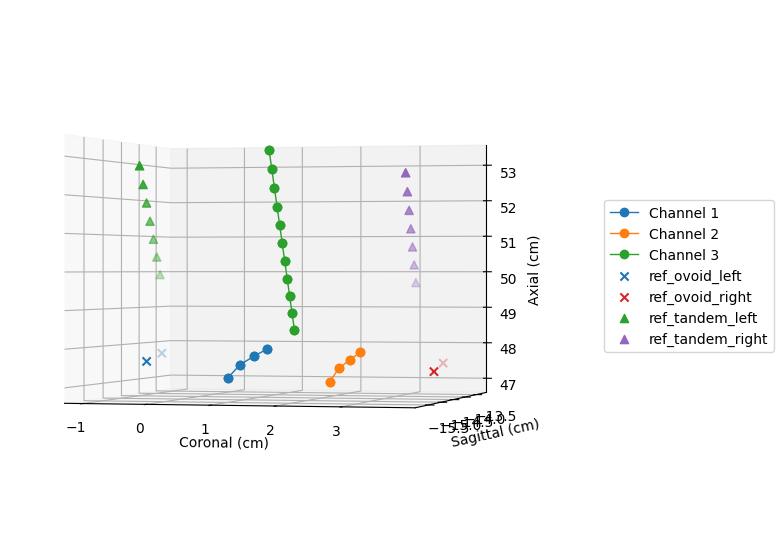

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for channel in rt_channels:
    pts = [p for p in channel.positions_cm if p is not None]
    if not pts:
        continue
    arr = np.asarray(pts, dtype=float)
    ax.plot(arr[:, 0], arr[:, 1], arr[:, 2], marker='o', linewidth=1.0, label=f"Channel {channel.channel_number}")

markers = {
    'ref_ovoid_left': ('x', '#1f77b4'),
    'ref_ovoid_right': ('x', '#d62728'),
    'ref_tandem_left': ('^', '#2ca02c'),
    'ref_tandem_right': ('^', '#9467bd'),
}
for label, pts in reference_sets.items():
    pts = np.asarray(pts, dtype=float)
    if pts.size == 0:
        continue
    marker, color = markers.get(label, ('x', 'black'))
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=35, marker=marker, color=color, label=label)

ax.set_xlabel('Coronal (cm)')
ax.set_ylabel('Sagittal (cm)')
ax.set_zlabel('Axial (cm)')
ax.view_init(elev=0, azim=-75, roll=0)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc='center left')
plt.tight_layout()
plt.show()

In [7]:
tables = dosecal.load_nucletron_tg43_tables(
    cfg["hyperparams"]["anisotropy_table"],
    cfg["hyperparams"]["radial_table"],
)
dwells, _ = dosecal.dwells_from_records(rt_channels)
channel_map = dataloader.map_channel_dwell_indices(rt_channels, dwells)
required_channels = ("ovoid_left", "ovoid_right", "tandem")
if len(channel_map) < len(required_channels):
    raise ValueError("Not enough channels found for T&O optimisation.")

dwell_indices: List[int] = []
dwell_records: List[Dict[str, Any]] = []
for channel_idx, label in enumerate(required_channels):
    indices = channel_map[channel_idx]
    channel = rt_channels[channel_idx]
    for local_idx, dwell_idx in enumerate(indices):
        dwell_indices.append(dwell_idx)
        dwell_records.append({
            "channel_label": label,
            "channel_number": channel.channel_number,
            "local_index": local_idx,
        })

opt_dwells = [dwells[i] for i in dwell_indices]
baseline_times = np.array([d.dwell_time_s for d in opt_dwells], dtype=float)
A_ref, target_doses_cgy, constraint_rows = build_reference_constraints(
    reference_sets, opt_dwells, tables, prescription_dose_cgy
)
print(f"Optimising {len(opt_dwells)} dwell positions with {A_ref.shape[0]} constraints")

Optimising 38 dwell positions with 18 constraints


In [8]:
delta = cp.Variable(baseline_times.shape[0])
updated_times = baseline_times + delta
constraints = [updated_times >= 0]
if A_ref.size:
    constraints.append(A_ref @ updated_times >= target_doses_cgy)
objective = cp.Minimize(cp.sum_squares(delta))
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.OSQP, warm_start=True)
print(f"Solver status: {prob.status}, objective: {prob.value:.4f}")
if prob.status not in ("optimal", "optimal_inaccurate"):
    raise RuntimeError("Convex optimisation failed to find a feasible solution.")
optimised_times = np.asarray(updated_times.value, dtype=float).ravel()

Solver status: optimal, objective: 996.1647


In [9]:
dwell_summary = pd.DataFrame(dwell_records)
dwell_summary["plan_time_s"] = baseline_times
dwell_summary["optimised_time_s"] = optimised_times
dwell_summary["delta_s"] = dwell_summary["optimised_time_s"] - dwell_summary["plan_time_s"]
plan_vals = dwell_summary["plan_time_s"].to_numpy()
with np.errstate(divide="ignore", invalid="ignore"):
    percent = np.where(
        np.abs(plan_vals) > 1e-6,
        dwell_summary["delta_s"] / dwell_summary["plan_time_s"],
        np.nan,
    )
dwell_summary["percent_change"] = percent
print(dwell_summary)

if A_ref.shape[0]:
    reference_report = pd.DataFrame(constraint_rows)
    reference_report["plan_dose_cgy"] = (A_ref @ baseline_times)
    reference_report["optimised_dose_cgy"] = (A_ref @ optimised_times)
    reference_report["slack_cgy"] = reference_report["optimised_dose_cgy"] - reference_report["target_dose_cgy"]
else:
    reference_report = pd.DataFrame(columns=[
        "group", "subset", "point_index", "point_cm", "target_dose_cgy",
        "plan_dose_cgy", "optimised_dose_cgy", "slack_cgy",
    ])
reference_report

   channel_label  channel_number  local_index  plan_time_s  optimised_time_s  \
0     ovoid_left               1            0     0.000000          5.962706   
1     ovoid_left               1            1     8.294523         14.169267   
2     ovoid_left               1            2     0.000000          7.419778   
3     ovoid_left               1            3     8.294523         15.714067   
4     ovoid_left               1            4     0.000000          8.217905   
5     ovoid_left               1            5     8.294523         16.511431   
6     ovoid_left               1            6     0.000000          7.583749   
7     ovoid_left               1            7     8.294523         15.879106   
8    ovoid_right               2            0     0.000000          5.844199   
9    ovoid_right               2            1     8.294523         14.065550   
10   ovoid_right               2            2     0.000000          7.252270   
11   ovoid_right               2        

,group,subset,point_index,point_cm,target_dose_cgy,plan_dose_cgy,optimised_dose_cgy,slack_cgy
0,ovoid,ref_ovoid_left,0,"[-0.9417683009584734, -13.924084526270855, 47....",840.0,427.634949,847.737129,7.737129e+00
1,ovoid,ref_ovoid_left,1,"[-0.9297637009584734, -14.387722326270856, 47....",840.0,419.930346,840.000000,1.136868e-13
2,ovoid,ref_ovoid_right,0,"[3.599154700958474, -13.601532773729147, 47.47...",840.0,431.052956,846.438411,6.438411e+00
3,ovoid,ref_ovoid_right,1,"[3.629671500958473, -14.063950773729147, 47.28...",840.0,423.961508,840.000000,0.000000e+00
4,tandem,ref_tandem_left,0,"[-0.22384743461129797, -15.782734568361137, 52...",600.0,489.318294,602.417572,2.417572e+00
5,tandem,ref_tandem_left,1,"[-0.2629895346112976, -15.621503268361138, 52....",600.0,533.975844,665.012324,6.501232e+01
6,tandem,ref_tandem_left,2,"[-0.3021315346112976, -15.460271968361138, 51....",600.0,562.747715,712.939607,1.129396e+02
7,tandem,ref_tandem_left,3,"[-0.3412735346112976, -15.299040668361137, 51....",600.0,579.201625,750.675499,1.506755e+02
8,tandem,ref_tandem_left,4,"[-0.3804155346112976, -15.137809368361138, 50....",600.0,587.052713,783.134342,1.831343e+02
9,tandem,ref_tandem_left,5,"[-0.41955753461129763, -14.976578168361137, 50...",600.0,588.832651,814.403972,2.144040e+02


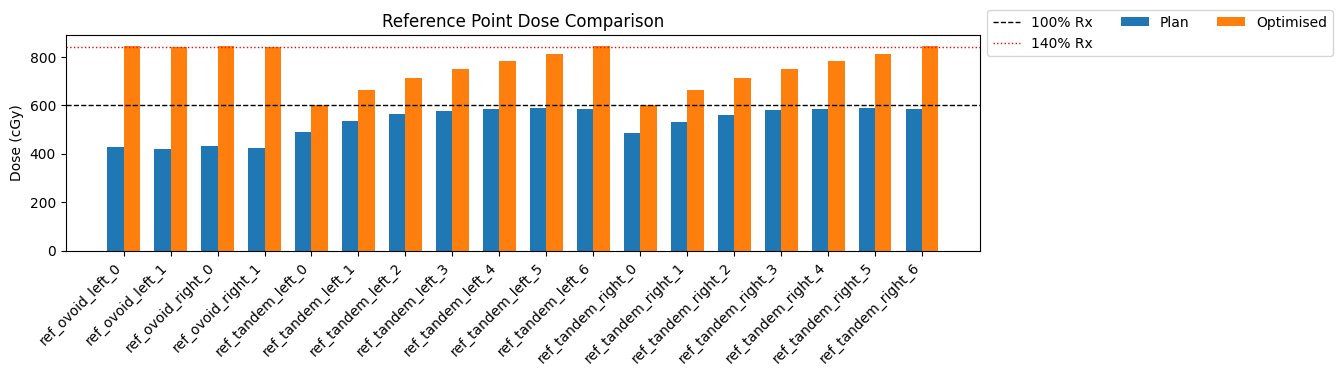

In [10]:
if reference_report.empty:
    print('No reference dose data available for plotting.')
else:
    df = reference_report.copy()
    df['label'] = df['subset'] + '_' + df['point_index'].astype(str)
    x = np.arange(len(df))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(x - width/2, df['plan_dose_cgy'], width, label='Plan')
    ax.bar(x + width/2, df['optimised_dose_cgy'], width, label='Optimised')
    ax.axhline(prescription_dose_cgy, color='k', linestyle='--', linewidth=1.0, label='100% Rx')
    ax.axhline(prescription_dose_cgy * 1.4, color='r', linestyle=':', linewidth=1.0, label='140% Rx')
    ax.set_xticks(x)
    ax.set_xticklabels(df['label'], rotation=45, ha='right')
    ax.set_ylabel('Dose (cGy)')
    ax.set_title('Reference Point Dose Comparison')
    ax.legend(ncol=3, bbox_to_anchor=(1.0, 1.15))
    plt.tight_layout()
    plt.show()

In [11]:
dwell_summary

,channel_label,channel_number,local_index,plan_time_s,optimised_time_s,delta_s,percent_change
0,ovoid_left,1,0,0.000000,5.962706,5.962706,NaN
1,ovoid_left,1,1,8.294523,14.169267,5.874744,0.708268
2,ovoid_left,1,2,0.000000,7.419778,7.419778,NaN
3,ovoid_left,1,3,8.294523,15.714067,7.419545,0.894511
4,ovoid_left,1,4,0.000000,8.217905,8.217905,NaN
5,ovoid_left,1,5,8.294523,16.511431,8.216909,0.990643
6,ovoid_left,1,6,0.000000,7.583749,7.583749,NaN
7,ovoid_left,1,7,8.294523,15.879106,7.584583,0.914409
8,ovoid_right,2,0,0.000000,5.844199,5.844199,NaN
9,ovoid_right,2,1,8.294523,14.065550,5.771027,0.695764


In [12]:
def expand_channel_dwell_times(channel, candidate_times, *, atol_cm: float = 1e-3):
    """Return dwell times aligned with the RTPLAN channel layout.

    Optimisation steps can drop duplicate dwell positions, so this function
    re-inserts zero-duration placeholders whenever consecutive control points
    share the same coordinates (within ``atol_cm``).
    """
    positions = [np.asarray(p, dtype=float) for p in channel.positions_cm if p is not None]
    candidate = np.asarray(candidate_times, dtype=float)
    if not positions:
        empty = np.zeros((0,), dtype=float)
        return empty, empty.astype(bool)

    duplicate_mask = np.zeros(len(positions), dtype=bool)
    if candidate.size == len(positions):
        return candidate.copy(), duplicate_mask

    expanded = []
    idx = 0
    prev = None
    for pos_idx, pos in enumerate(positions):
        if prev is not None:
            expanded.append(0.0)
            duplicate_mask[pos_idx] = True
            continue
        if idx >= candidate.size:
            raise ValueError("Optimised dwell list shorter than channel topology.")
        expanded.append(float(candidate[idx]))
        idx += 1
        prev = pos
    if idx != candidate.size:
        raise ValueError("Optimised dwell list longer than channel topology.")
    return np.asarray(expanded, dtype=float), duplicate_mask


In [13]:
dwell_summary_sorted = dwell_summary.sort_values(["channel_label", "local_index"]).reset_index(drop=True)
updated_dwells = copy.deepcopy(dwells)
applied_rows = []
duplicate_report: Dict[str, int] = {}

for channel_idx, label in enumerate(required_channels):
    channel = rt_channels[channel_idx]
    indices = channel_map[channel_idx]
    candidate = dwell_summary_sorted.loc[
        dwell_summary_sorted["channel_label"] == label,
        "optimised_time_s",
    ].to_numpy()
    expanded_times, duplicate_mask = expand_channel_dwell_times(channel, candidate, atol_cm=1e-4)
    if expanded_times.size != len(indices):
        raise ValueError(
            f"Expanded dwell schedule for {label} has {expanded_times.size} entries, "
            f"but the RTPLAN channel expects {len(indices)}."
        )
    duplicate_report[label] = int(duplicate_mask.sum())
    for local_idx, (dwell_idx, new_time, is_dup) in enumerate(zip(indices, expanded_times, duplicate_mask)):
        baseline_time = dwells[dwell_idx].dwell_time_s
        updated_dwells[dwell_idx].dwell_time_s = float(new_time)
        applied_rows.append({
            "channel_label": label,
            "channel_number": channel.channel_number,
            "local_index": local_idx,
            "dwell_index": dwell_idx,
            "is_duplicate": bool(is_dup),
            "plan_time_s": baseline_time,
            "optimised_time_s": new_time,
            "delta_s": new_time - baseline_time,
        })

scaled_channels = dosecal.rebuild_channels(rt_channels, updated_dwells)

print("Restored duplicate dwell placeholders per channel:")
for label in required_channels:
    print(f"  {label}: {duplicate_report.get(label, 0)}")

applied_dwell_summary = pd.DataFrame(applied_rows)
applied_dwell_summary


Restored duplicate dwell placeholders per channel:
  ovoid_left: 0
  ovoid_right: 0
  tandem: 0


,channel_label,channel_number,local_index,dwell_index,is_duplicate,plan_time_s,optimised_time_s,delta_s
0,ovoid_left,1,0,0,False,0.000000,5.962706,5.962706
1,ovoid_left,1,1,1,False,8.294523,14.169267,5.874744
2,ovoid_left,1,2,2,False,0.000000,7.419778,7.419778
3,ovoid_left,1,3,3,False,8.294523,15.714067,7.419545
4,ovoid_left,1,4,4,False,0.000000,8.217905,8.217905
5,ovoid_left,1,5,5,False,8.294523,16.511431,8.216909
6,ovoid_left,1,6,6,False,0.000000,7.583749,7.583749
7,ovoid_left,1,7,7,False,8.294523,15.879106,7.584583
8,ovoid_right,2,0,8,False,0.000000,5.844199,5.844199
9,ovoid_right,2,1,9,False,8.294523,14.065550,5.771027


In [14]:
updated_dwells

[DwellPoint(position_cm=array([  0.5379861, -13.3453959,  47.7999833]), axis=array([0., 0., 1.]), dwell_time_s=5.9627063398613105, source_strength_U=40688.7810679625),
 DwellPoint(position_cm=array([  0.5379861, -13.3453959,  47.7999833]), axis=array([ 0.0287272 , -0.94515884, -0.32534521]), dwell_time_s=14.16926692574258, source_strength_U=40688.7810679625),
 DwellPoint(position_cm=array([  0.5523497, -13.8179753,  47.6373107]), axis=array([ 0.0287272 , -0.94515884, -0.32534521]), dwell_time_s=7.419778269379859, source_strength_U=40688.7810679625),
 DwellPoint(position_cm=array([  0.5523497, -13.8179753,  47.6373107]), axis=array([ 0.02405191, -0.92892523, -0.36948535]), dwell_time_s=15.714067192484782, source_strength_U=40688.7810679625),
 DwellPoint(position_cm=array([  0.5643543, -14.2816131,  47.4528961]), axis=array([ 0.02405191, -0.92892523, -0.36948535]), dwell_time_s=8.217905061577417, source_strength_U=40688.7810679625),
 DwellPoint(position_cm=array([  0.5643543, -14.2816131

In [15]:
# Rotate CT/Dose volumes so the applicator aligns with axial/coronal/sagittal axes
def build_applicator_frame(rt_channels):
    pos_left = np.vstack([p for p in rt_channels[0].positions_cm if p is not None])
    pos_right = np.vstack([p for p in rt_channels[1].positions_cm if p is not None])
    pos_tandem = np.vstack([p for p in rt_channels[2].positions_cm if p is not None])
    left_center = pos_left.mean(axis=0)
    right_center = pos_right.mean(axis=0)
    tandem_axis = pos_tandem[-1] - pos_tandem[0]
    lateral_axis = right_center - left_center
    tandem_dir = tandem_axis / np.linalg.norm(tandem_axis)
    lateral_axis -= tandem_dir * np.dot(lateral_axis, tandem_dir)
    lateral_dir = lateral_axis / np.linalg.norm(lateral_axis)
    anterior_dir = np.cross(tandem_dir, lateral_dir)
    anterior_dir /= np.linalg.norm(anterior_dir)
    rotation = np.vstack([lateral_dir, anterior_dir, tandem_dir])
    center = (pos_tandem[0] + pos_tandem[-1]) / 2
    return rotation, center

def rotate_volume(image, rotation, center_cm, *, interpolator=sitk.sitkNearestNeighbor, default_value=0):
    transform = sitk.AffineTransform(3)
    transform.SetMatrix(rotation.flatten())                  # rotation rows are new axes
    transform.SetCenter(tuple((center_cm * 10.0).tolist()))  # cm → mm

    resampled = sitk.Resample(
        image,
        image,                      # use same grid as reference
        transform.GetInverse(),     # map output coords → input coords
        interpolator,
        default_value,
        image.GetPixelID(),
    )
    return resampled

def rotate_points(points_cm, rotation, center_cm):
    pts = np.asarray(points_cm, dtype=float)
    rel = pts - center_cm[np.newaxis, :]
    rotated = (rotation @ rel.T).T + center_cm  # shape (N, 3)
    return rotated


ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(paths["ct"])
ct_array.shape

dose_result = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=scaled_channels,
    anisotropy_path=cfg['hyperparams']['anisotropy_table'],
    radial_path=cfg['hyperparams']['radial_table'],
)

rotation_matrix, rotation_center = build_applicator_frame(rt_channels)
rotated_ct_image = rotate_volume(ct_image, rotation_matrix, rotation_center)
rotated_ct_array = sitk.GetArrayFromImage(rotated_ct_image)
rotated_dose_image = rotate_volume(dose_result.resampled_image, rotation_matrix, rotation_center)
rotated_dose_array = sitk.GetArrayFromImage(rotated_dose_image)

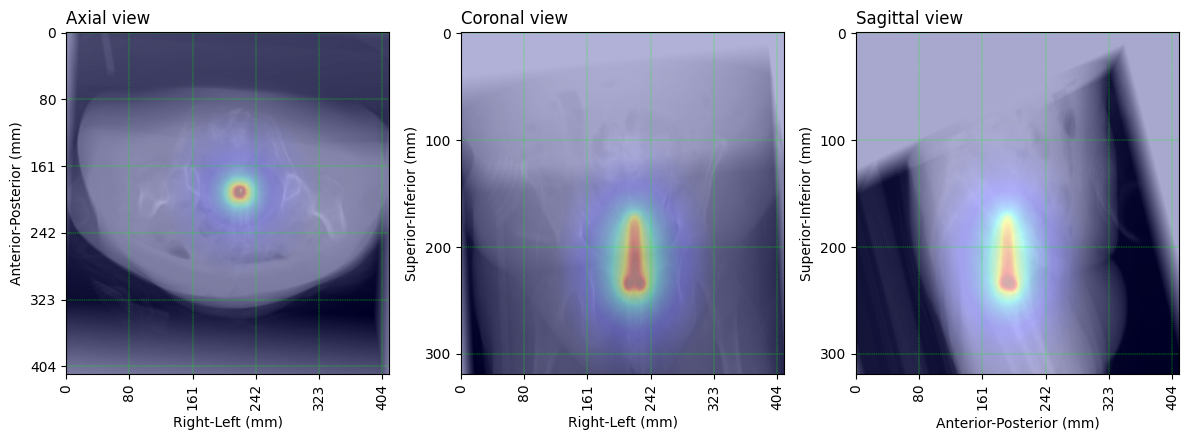

In [16]:
ct_view = rotated_ct_array
dose_overlay = utils.dose_clip(rotated_dose_array, 0, 3000)
# np.save(save_dir / f"{save_name}.npy", dose_overlay)

x_ticks = range(ct_metadata["size"][0])
y_ticks = range(ct_metadata["size"][1])
z_ticks = range(ct_metadata["size"][2])

x_coords_mm = np.array(np.array(x_ticks) * ct_metadata["spacing"][0], dtype=int)
y_coords_mm = np.array(np.array(y_ticks) * ct_metadata["spacing"][1], dtype=int)
z_coords_mm = np.array(np.array(z_ticks) * ct_metadata["spacing"][2], dtype=int)

tick_step = 100
z_tick_step = max(1, tick_step // 2)
alpha = 0.3

plt.figure(figsize=(12, 4.5), dpi=100)

plt.subplot(1, 3, 1)
plt.title("Axial view", loc="left")
plt.imshow(np.sum(ct_view, axis=0), aspect="auto", cmap="gray")
plt.imshow(np.sum(dose_overlay, axis=0), aspect="auto", cmap="jet", alpha=alpha)
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1))
plt.xlabel("Right-Left (mm)")
plt.ylabel("Anterior-Posterior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 2)
plt.title("Coronal view", loc="left")
plt.imshow(np.sum(ct_view, axis=1), aspect="auto", cmap="gray")
plt.imshow(np.sum(dose_overlay, axis=1), aspect="auto", cmap="jet", alpha=alpha)
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
plt.xlabel("Right-Left (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 3)
plt.title("Sagittal view", loc="left")
plt.imshow(np.sum(ct_view, axis=2), aspect="auto", cmap="gray")
plt.imshow(np.sum(dose_overlay, axis=2), aspect="auto", cmap="jet", alpha=alpha)
plt.xticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
plt.xlabel("Anterior-Posterior (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.tight_layout()
plt.show()

In [17]:
def physical_to_voxel(image, points_cm):
    points_mm = np.asarray(points_cm, dtype=float) * 10.0

    origin_mm = np.array(image.GetOrigin(), dtype=float)
    spacing_mm = np.array(image.GetSpacing(), dtype=float)
    direction = np.array(image.GetDirection(), dtype=float).reshape(3, 3)

    # Convert patient-space mm → continuous voxel indices
    rel = points_mm - origin_mm
    direction_inv = np.linalg.inv(direction)
    indices = (direction_inv @ rel.T).T / spacing_mm

    return indices

rotated_dwells = []
for channel in rt_channels:
    pts_cm = [p for p in channel.positions_cm if p is not None]
    if not pts_cm:
        continue
    rotated = rotate_points(pts_cm, rotation_matrix, rotation_center)
    rotated_dwells.append(physical_to_voxel(rotated_ct_image, rotated))

rotated_ref_ovoid_left = physical_to_voxel(rotated_ct_image, rotate_points(reference_sets['ref_ovoid_left'], rotation_matrix, rotation_center))
rotated_ref_ovoid_right = physical_to_voxel(rotated_ct_image, rotate_points(reference_sets['ref_ovoid_right'], rotation_matrix, rotation_center))
rotated_ref_tandem_left = physical_to_voxel(rotated_ct_image, rotate_points(reference_sets['ref_tandem_left'], rotation_matrix, rotation_center))
rotated_ref_tandem_right = physical_to_voxel(rotated_ct_image, rotate_points(reference_sets['ref_tandem_right'], rotation_matrix, rotation_center))

## Python Plan

600 [ 300.  600. 1200.]


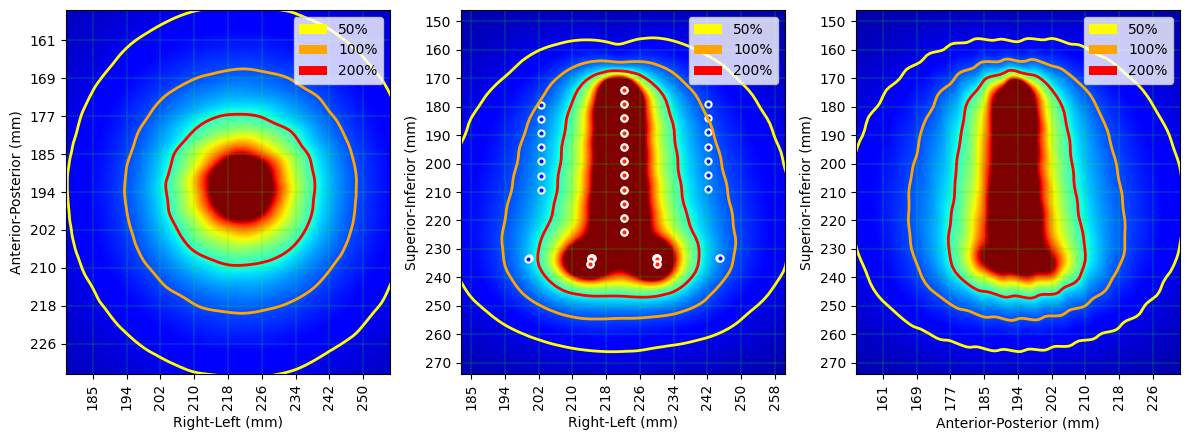

In [18]:
dose_result = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=scaled_channels,
    anisotropy_path=cfg['hyperparams']['anisotropy_table'],
    radial_path=cfg['hyperparams']['radial_table'],
)

rotated_dose_image = rotate_volume(dose_result.resampled_image, rotation_matrix, rotation_center)
rotated_dose_array = sitk.GetArrayFromImage(rotated_dose_image)

rotated_dose_array = gaussian_filter(rotated_dose_array, sigma=1)

dose_overlay = rotated_dose_array
view_axial = dose_overlay[112, :, :]
view_coronal = dose_overlay[:, 240, :]
view_sagittal = dose_overlay[:, :, 270]
slice_axial = rotated_dose_array[112, :, :] 
slice_coronal = rotated_dose_array[:, 240, :]
slice_sagittal = rotated_dose_array[:, :, 270]


vmin, vmax = 0, prescription_dose_cgy * 5
iso_levels = np.array([0.5, 1.0, 2.0]) * prescription_dose_cgy  # cGy
iso_colors = ["yellow","orange","red"]
iso_labels = ['50%', '100%', '200%']
print(prescription_dose_cgy, iso_levels)

fontsize = 8 
tick_step = 10
z_tick_step = max(1, tick_step // 2)
alpha = 0.3

plt.figure(figsize=(12, 4.5), dpi=100)

plt.subplot(1, 3, 1)
plt.imshow(view_axial, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs1= plt.contour(slice_axial, levels=iso_levels, colors=iso_colors, linewidths=2.0)
proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
plt.legend(proxy, iso_labels)
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1))
x_center = 270
y_center = 240
size_zoom = 96
plt.xlim(x_center-size_zoom//2, x_center+size_zoom//2)
plt.ylim(y_center+size_zoom//2, y_center-size_zoom//2)
plt.xlabel("Right-Left (mm)")
plt.ylabel("Anterior-Posterior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 2)
plt.imshow(view_coronal, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs2 = plt.contour(slice_coronal, levels=iso_levels, colors=iso_colors, linewidths=2.0)
proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
plt.legend(proxy, iso_labels)
plt.scatter(rotated_dwells[0][:, 0], rotated_dwells[0][:, 2], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#ff2600")
plt.scatter(rotated_dwells[1][:, 0], rotated_dwells[1][:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color='#ff2600')
plt.scatter(rotated_dwells[2][:, 0], rotated_dwells[2][:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color='#ff2600')
plt.scatter(rotated_ref_ovoid_left[:, 0], rotated_ref_ovoid_left[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")
plt.scatter(rotated_ref_ovoid_right[:, 0], rotated_ref_ovoid_right[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")
plt.scatter(rotated_ref_tandem_left[:, 0], rotated_ref_tandem_left[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")
plt.scatter(rotated_ref_tandem_right[:, 0], rotated_ref_tandem_right[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
x_center = 275
y_center = 105
size_zoom_x = 96
size_zoom_y = 64
plt.xlim(x_center-size_zoom_x//2, x_center+size_zoom_x//2)
plt.ylim(y_center+size_zoom_y//2, y_center-size_zoom_y//2)
plt.xlabel("Right-Left (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 3)
plt.imshow(view_sagittal, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs3= plt.contour(slice_sagittal, levels=iso_levels, colors=iso_colors, linewidths=2.0)
proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
plt.legend(proxy, iso_labels)
plt.xticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
x_center = 240
y_center = 105
size_zoom_x = 96
size_zoom_y = 64
plt.xlim(x_center-size_zoom_x//2, x_center+size_zoom_x//2)
plt.ylim(y_center+size_zoom_y//2, y_center-size_zoom_y//2)
plt.xlabel("Anterior-Posterior (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.tight_layout()
plt.show()

## Library Plan

600 [ 300.  600. 1200.]


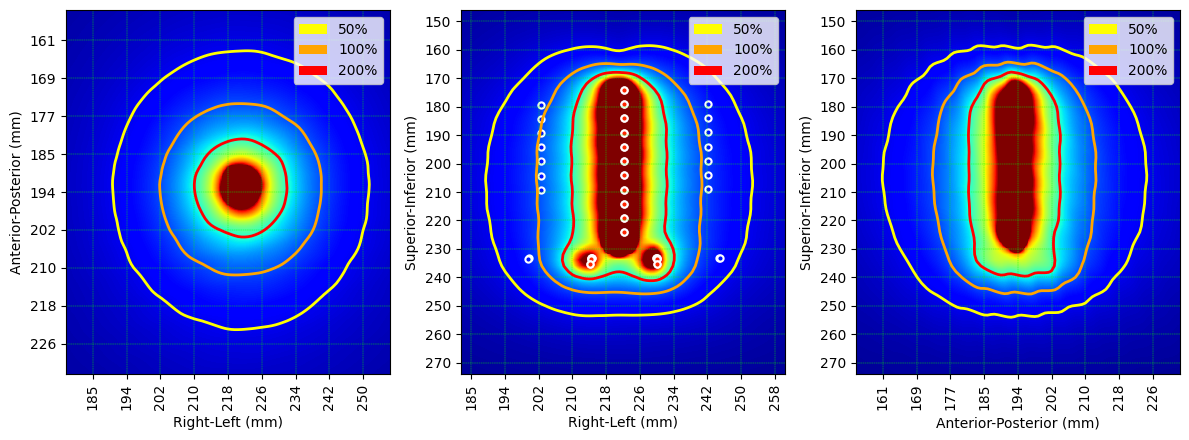

In [19]:
dose_original = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=rt_channels,
    anisotropy_path=cfg['hyperparams']['anisotropy_table'],
    radial_path=cfg['hyperparams']['radial_table'],
)

rotated_dose_image_original = rotate_volume(dose_original.resampled_image, rotation_matrix, rotation_center)
rotated_dose_array_original = sitk.GetArrayFromImage(rotated_dose_image_original)
rotated_dose_array_original = gaussian_filter(rotated_dose_array_original, sigma=1)

dose_overlay = rotated_dose_array_original
view_axial = dose_overlay[112, :, :]
view_coronal = dose_overlay[:, 240, :]
view_sagittal = dose_overlay[:, :, 270]
slice_axial = rotated_dose_array_original[112, :, :] 
slice_coronal = rotated_dose_array_original[:, 240, :]
slice_sagittal = rotated_dose_array_original[:, :, 270]


vmin, vmax = 0, prescription_dose_cgy * 5
iso_levels = np.array([0.5, 1.0, 2.0]) * prescription_dose_cgy  # cGy
iso_colors = ["yellow","orange","red"]
iso_labels = ['50%', '100%', '200%']
print(prescription_dose_cgy, iso_levels)

fontsize = 8 
tick_step = 10
z_tick_step = max(1, tick_step // 2)
alpha = 0.3

plt.figure(figsize=(12, 4.5), dpi=100)

plt.subplot(1, 3, 1)
plt.imshow(view_axial, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs1= plt.contour(slice_axial, levels=iso_levels, colors=iso_colors, linewidths=2.0)
proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
plt.legend(proxy, iso_labels)
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1))
x_center = 270
y_center = 240
size_zoom = 96
plt.xlim(x_center-size_zoom//2, x_center+size_zoom//2)
plt.ylim(y_center+size_zoom//2, y_center-size_zoom//2)
plt.xlabel("Right-Left (mm)")
plt.ylabel("Anterior-Posterior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 2)
plt.imshow(view_coronal, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs2 = plt.contour(slice_coronal, levels=iso_levels, colors=iso_colors, linewidths=2.0)
proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
plt.legend(proxy, iso_labels)
plt.scatter(rotated_dwells[0][:, 0], rotated_dwells[0][:, 2], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#ff2600")
plt.scatter(rotated_dwells[1][:, 0], rotated_dwells[1][:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color='#ff2600')
plt.scatter(rotated_dwells[2][:, 0], rotated_dwells[2][:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color='#ff2600')
plt.scatter(rotated_ref_ovoid_left[:, 0], rotated_ref_ovoid_left[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")
plt.scatter(rotated_ref_ovoid_right[:, 0], rotated_ref_ovoid_right[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")
plt.scatter(rotated_ref_tandem_left[:, 0], rotated_ref_tandem_left[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")
plt.scatter(rotated_ref_tandem_right[:, 0], rotated_ref_tandem_right[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
x_center = 275
y_center = 105
size_zoom_x = 96
size_zoom_y = 64
plt.xlim(x_center-size_zoom_x//2, x_center+size_zoom_x//2)
plt.ylim(y_center+size_zoom_y//2, y_center-size_zoom_y//2)
plt.xlabel("Right-Left (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 3)
plt.imshow(view_sagittal, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs3= plt.contour(slice_sagittal, levels=iso_levels, colors=iso_colors, linewidths=2.0)
proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
plt.legend(proxy, iso_labels)
plt.xticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
x_center = 240
y_center = 105
size_zoom_x = 96
size_zoom_y = 64
plt.xlim(x_center-size_zoom_x//2, x_center+size_zoom_x//2)
plt.ylim(y_center+size_zoom_y//2, y_center-size_zoom_y//2)
plt.xlabel("Anterior-Posterior (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.tight_layout()
plt.show()

In [20]:
import copy
import importlib
importlib.reload(chelp)
importlib.reload(rtexport)

rtstruct = chelp.load_rtstruct(paths["struct"])
slice_uid_map = rtexport.map_ct_slice_uids(
    paths["ct"],
    reference_image=ct_image,
)

case_label = getattr(case_id, "name", str(case_id)) or "case"

rtstruct_optimized = copy.copy(rtstruct)
rtstruct_optimized = rtexport.embed_mask_as_structure(
    rtstruct_optimized,
    mask=dose_result.resampled_array >= prescription_dose_cgy,
    reference_image=ct_image,
    slice_uid_map=slice_uid_map,
    roi_name="ISO100",
    color=(0, 176, 255),
    description=f"100% prescription ({prescription_dose_cgy} cGy) isodose",
)
rtstruct_optimized = rtexport.embed_mask_as_structure(
    rtstruct_optimized,
    mask=dose_result.resampled_array >= prescription_dose_cgy*2,
    reference_image=ct_image,
    slice_uid_map=slice_uid_map,
    roi_name="ISO200",
    color=(0, 176, 255),
    description=f"200% prescription ({prescription_dose_cgy} cGy) isodose",
)

rtstruct_original = copy.copy(rtstruct)
rtstruct_original = rtexport.embed_mask_as_structure(
    rtstruct_original,
    mask=dose_original.resampled_array >= prescription_dose_cgy,
    reference_image=ct_image,
    slice_uid_map=slice_uid_map,
    roi_name="ISO100",
    color=(255, 128, 0),
    description=f"100% prescription ({prescription_dose_cgy} cGy) isodose",
)
rtstruct_original = rtexport.embed_mask_as_structure(
    rtstruct_original,
    mask=dose_original.resampled_array >= prescription_dose_cgy*2,
    reference_image=ct_image,
    slice_uid_map=slice_uid_map,
    roi_name="ISO200",
    color=(255, 128, 0),
    description=f"200% prescription ({prescription_dose_cgy} cGy) isodose",
)

optimized_output = Path.cwd() / f"{case_label}_iso100_optimized_rtstruct.dcm"
original_output = Path.cwd() / f"{case_label}_iso100_original_rtstruct.dcm"

optimized_path = rtexport.write_rtstruct(rtstruct_optimized, optimized_output)
original_path = rtexport.write_rtstruct(rtstruct_original, original_output)

print(f"Saved optimised RTSTRUCT: {optimized_path}")
print(f"Saved baseline RTSTRUCT: {original_path}")


Saved optimised RTSTRUCT: /home/ypark6/dose_prediction/Case6_iso100_optimized_rtstruct.dcm
Saved baseline RTSTRUCT: /home/ypark6/dose_prediction/Case6_iso100_original_rtstruct.dcm


Bladder (160, 512, 512) 210.16906210327147
Rectum (160, 512, 512) 78.20387100219726
Sigmoid (160, 512, 512) 183.42243594360352
Bowel (160, 512, 512) 206.2238889770508
HR-CTV (160, 512, 512) 27.07223043823242
ISO100 (160, 512, 512) 147.36012753295898
ISO200 (160, 512, 512) 51.36701715087891


/tmp/ipykernel_296707/2682402398.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


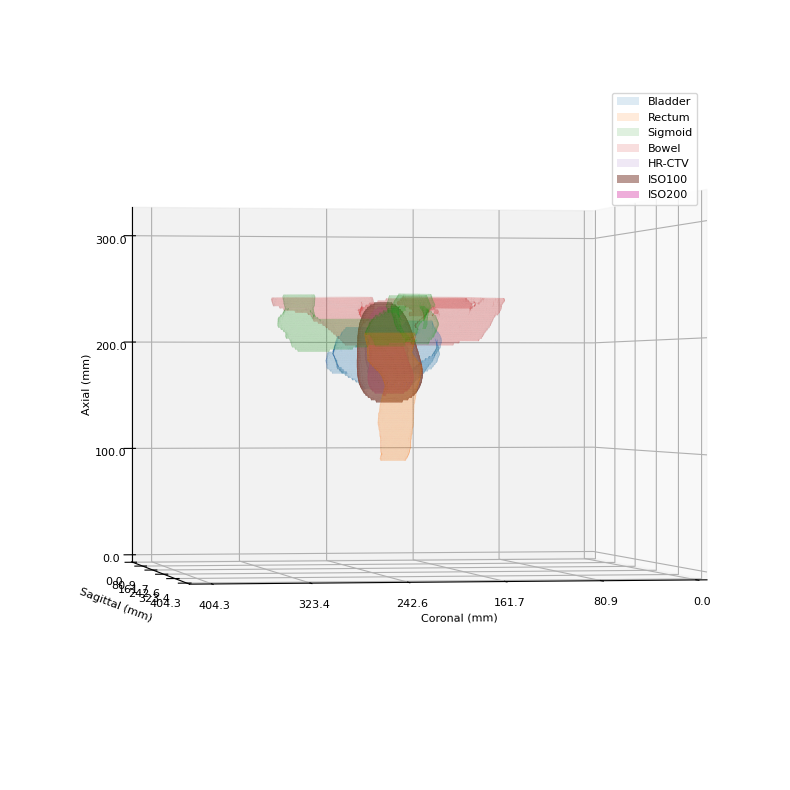

In [21]:
import matplotlib.colors as mcolors
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(paths["ct"])
rtstruct = chelp.load_rtstruct("/home/ypark6/dose_prediction/Case6_iso100_optimized_rtstruct.dcm")

list_contour = ['Bladder', 'Rectum', 'Sigmoid', 'Bowel', 'HR-CTV', 'ISO100', 'ISO200']

list_colors = list(mcolors.TABLEAU_COLORS.values())
fontsize = 8
tickstep = 100
x_ticks = range(ct_metadata['size'][0])
y_ticks = range(ct_metadata['size'][1])
z_ticks = range(ct_metadata['size'][2])
x_mms = np.array(x_ticks)*ct_metadata['spacing'][0]
y_mms = np.array(y_ticks)*ct_metadata['spacing'][1]
z_mms = np.array(z_ticks)*ct_metadata['spacing'][2]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for idx, name in enumerate(list_contour):
    try: mask = chelp.rasterise_structure(rtstruct, name, ct_image)
    except: continue
    if mask is None: continue
    print(name, mask.shape, np.sum(mask)*np.prod(ct_metadata['spacing'])/(10**3))

    verts, faces, normals, values = measure.marching_cubes(mask.transpose(2,1,0), 0)
    if 'ISO' in name:
        alpha=0.6
    else:   
        alpha=0.15
    mesh = Poly3DCollection(verts[faces], alpha=alpha, label=name)
    mesh.set_facecolor(list_colors[idx])
    ax.add_collection3d(mesh)

ax.set_xticks(ticks=x_ticks[::tickstep], labels=np.round(x_mms[::tickstep], 1), fontsize=fontsize)
ax.set_yticks(ticks=y_ticks[::tickstep], labels=np.round(y_mms[::tickstep], 1), fontsize=fontsize)
ax.set_zticks(ticks=z_ticks[::tickstep//2], labels=np.round(z_mms[::tickstep//2], 1), fontsize=fontsize)
ax.set_xlabel('Coronal (mm)', fontsize=fontsize)
ax.set_ylabel('Sagittal (mm)', fontsize=fontsize)
ax.set_zlabel('Axial (mm)', fontsize=fontsize)
ax.set_xlim(0, ct_metadata['size'][0])
ax.set_ylim(0, ct_metadata['size'][1])
ax.set_zlim(0, ct_metadata['size'][2])

ax.view_init(elev=0, azim=80, roll=0)

plt.legend(bbox_to_anchor=(0.9, 0.9), loc='upper right', fontsize=fontsize)
plt.tight_layout()
plt.show()

Bladder (160, 512, 512) 210.16906210327147


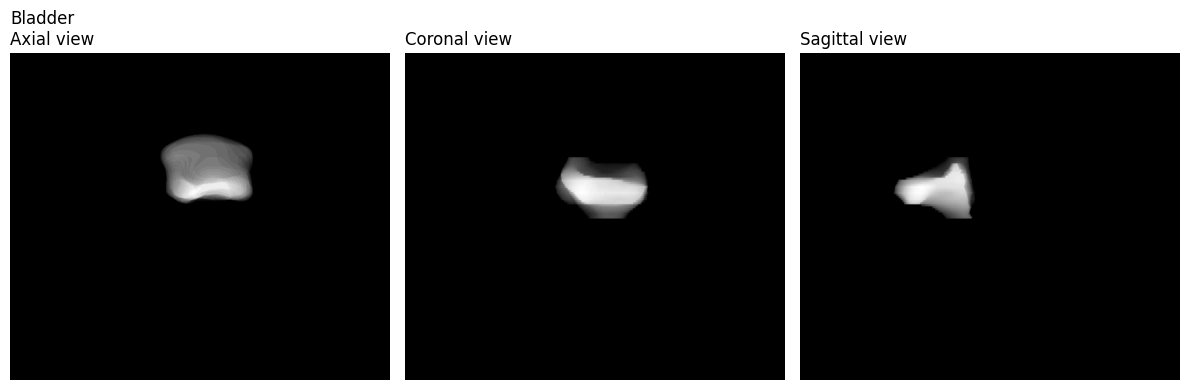

Rectum (160, 512, 512) 78.20387100219726


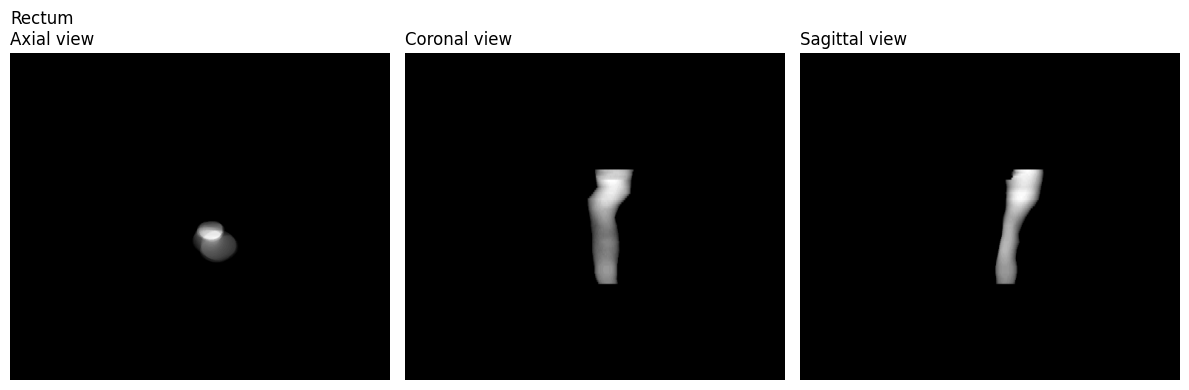

Sigmoid (160, 512, 512) 183.42243594360352


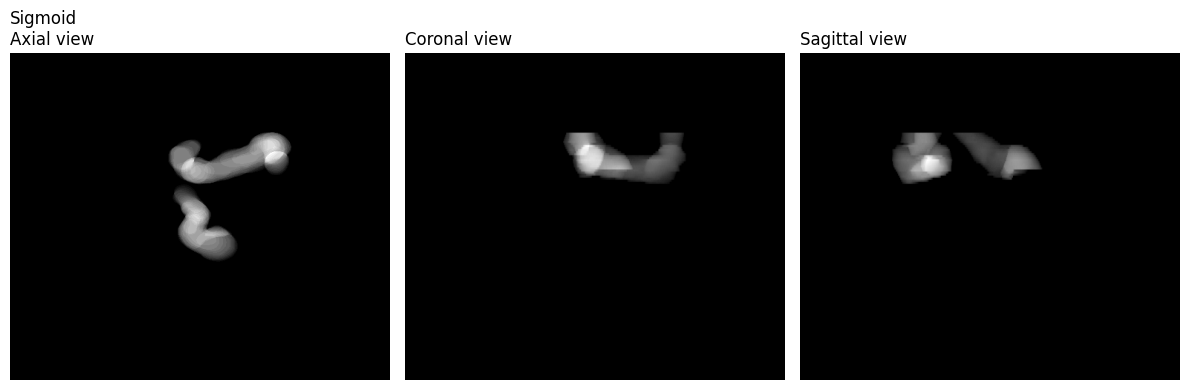

Bowel (160, 512, 512) 206.2238889770508


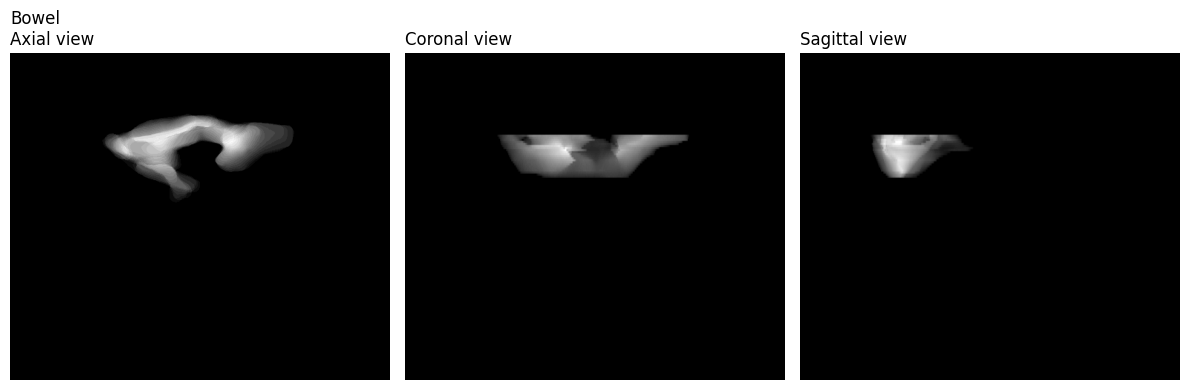

HR-CTV (160, 512, 512) 27.07223043823242


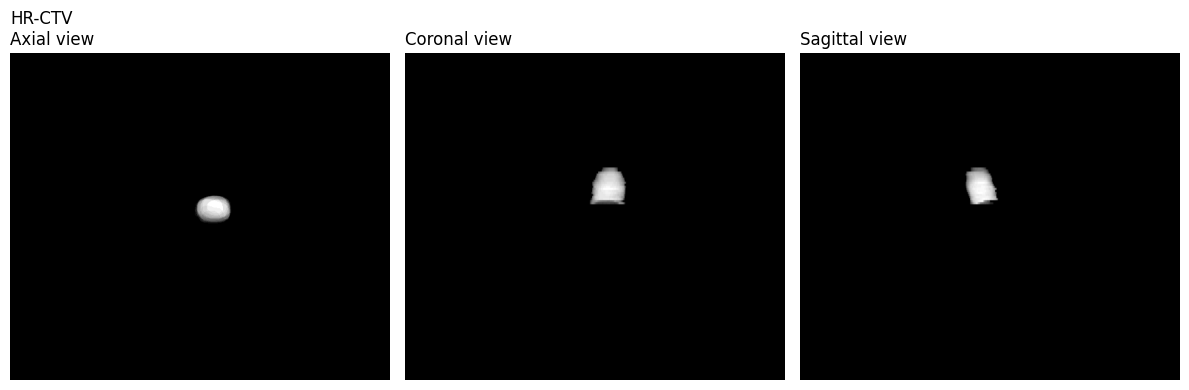

ISO100 (160, 512, 512) 147.36012753295898


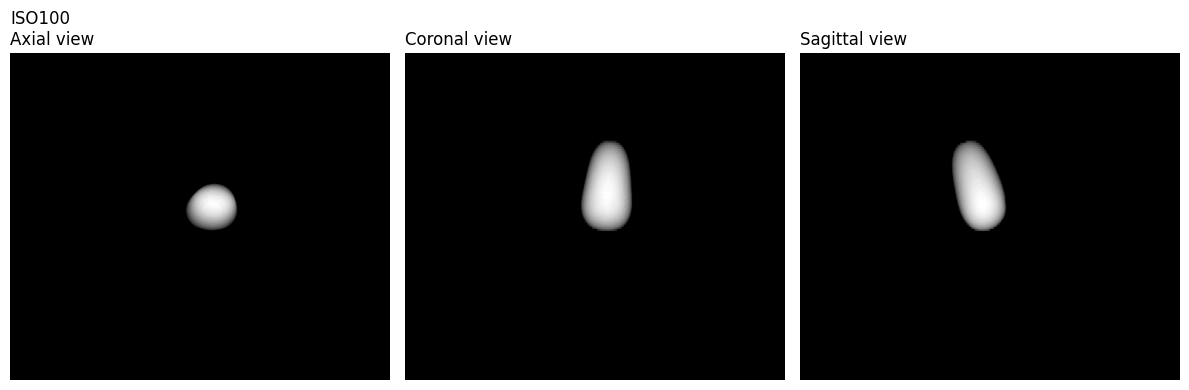

ISO200 (160, 512, 512) 51.36701715087891


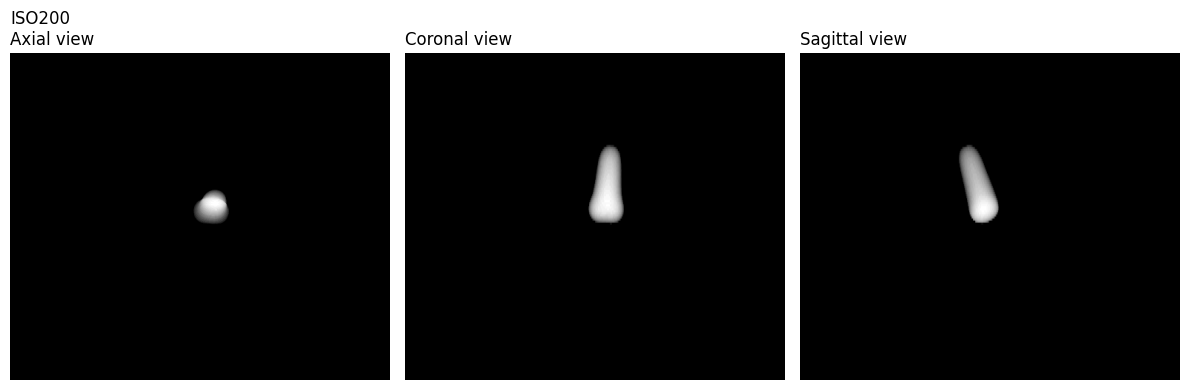

In [26]:
for idx, name in enumerate(list_contour):
    try: mask = chelp.rasterise_structure(rtstruct, name, ct_image)
    except: continue
    if mask is None: continue
    print(name, mask.shape, np.sum(mask)*np.prod(ct_metadata['spacing'])/(10**3))

    mask = mask[::-1]
    plt.figure(figsize=(12, 4), dpi=100)
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title(f"{name}\nAxial view", loc="left")
    plt.imshow(np.sum(mask, axis=0), aspect="auto", cmap="gray")
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.title("Coronal view", loc="left")
    plt.imshow(np.sum(mask, axis=1), aspect="auto", cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.title("Sagittal view", loc="left")
    plt.imshow(np.sum(mask, axis=2), aspect="auto", cmap="gray")
    plt.tight_layout()
    plt.show()